In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from livelossplot.tf_keras import PlotLossesCallback

In [2]:
train_images = pd.read_csv('./dataset/train/images.csv',header=None)
train_labels = pd.read_csv('./dataset/train/labels.csv', header=None)

test_images = pd.read_csv('./dataset/validation/images.csv', header=None)
test_labels = pd.read_csv('./dataset/validation/labels.csv',header=None)

In [3]:
train_images.head()

,0,1,2,3,4,5,6,7,8,9,...,8182,8183,8184,8185,8186,8187,8188,8189,8190,8191
0,0.631373,0.623529,0.713726,0.705882,0.658824,0.666667,0.654902,0.635294,0.647059,0.705882,...,0.682353,0.611765,0.650980,0.658824,0.600000,0.603922,0.654902,0.694118,0.658824,0.666667
1,0.725490,0.752941,0.749020,0.701961,0.690196,0.721569,0.709804,0.745098,0.654902,0.721569,...,0.721569,0.698039,0.721569,0.686275,0.713726,0.682353,0.690196,0.698039,0.701961,0.725490
2,0.717647,0.701961,0.713726,0.733333,0.705882,0.717647,0.725490,0.682353,0.717647,0.674510,...,0.709804,0.694118,0.705882,0.682353,0.639216,0.713726,0.670588,0.678431,0.737255,0.674510
3,0.705882,0.674510,0.654902,0.678431,0.666667,0.662745,0.678431,0.662745,0.686275,0.686275,...,0.639216,0.662745,0.631373,0.643137,0.705882,0.662745,0.705882,0.666667,0.654902,0.631373
4,0.647059,0.729412,0.701961,0.674510,0.611765,0.698039,0.713726,0.662745,0.701961,0.674510,...,0.639216,0.670588,0.705882,0.674510,0.721569,0.694118,0.674510,0.705882,0.749020,0.729412


In [4]:
train_labels.head()

,0,1,2,3
0,1.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0


In [5]:
train_images.shape, train_labels.shape

((3200, 8192), (3200, 4))

In [6]:
test_images.shape, test_labels.shape

((800, 8192), (800, 4))

In [7]:
x_train = train_images.values.reshape(3200,64,128,1)
x_val = test_images.values.reshape(800,64,128,1)

y_train = train_labels.values
y_val = test_labels.values

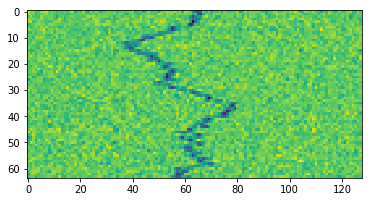

In [8]:
img = np.squeeze(x_train[200])
plt.imshow(img)

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [10]:
train_datagen = ImageDataGenerator(horizontal_flip=True)
train_datagen.fit(x_train)

test_datagen = ImageDataGenerator(horizontal_flip=True)
test_datagen.fit(x_val)

In [11]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, BatchNormalization, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam, SGD

In [12]:
model = Sequential()
model.add(Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(64,128,1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.1))

model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Flatten())

model.add(Dense(1024, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Dense(4, activation='softmax'))

In [13]:
initial_learning_rate = 0.01
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=5,
    decay_rate=0.96,
    staircase=True
)

In [14]:
optimizer = Adam(learning_rate=lr_schedule)

In [15]:
model.compile(optimizer=optimizer,loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 128, 32)       320       
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 128, 32)       128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 64, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 64, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 64, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 32, 64)        0

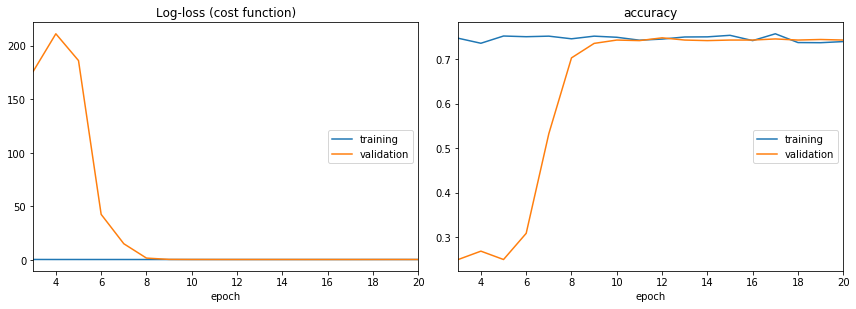

Log-loss (cost function):
training   (min:    0.385, max:    0.739, cur:    0.391)
validation (min:    0.386, max:  211.193, cur:    0.398)

accuracy:
training   (min:    0.688, max:    0.757, cur:    0.739)
validation (min:    0.250, max:    0.748, cur:    0.743)

Epoch 00020: saving model to model.h5
100/100 [==============================] - 110s 1s/step - loss: 0.3907 - accuracy: 0.7391 - val_loss: 0.3977 - val_accuracy: 0.7425


In [16]:
checkpoint = ModelCheckpoint('model.h5',monitor='val_loss', verbose=1, mode='min')
callbacks = [PlotLossesCallback(), checkpoint]
batch_size=32
h = model.fit(train_datagen.flow(x_train,y_train,batch_size=batch_size, shuffle=True),
             steps_per_epoch=len(x_train)//batch_size,
              validation_data=test_datagen.flow(x_val,y_val,batch_size=batch_size,shuffle=True),
              validation_steps=len(x_val)//batch_size,
              epochs=20,
              callbacks=callbacks
             )

In [18]:
model.evaluate(x_val,y_val,verbose=0)

[0.38494522862834857, 0.74625]

In [18]:
import seaborn as sns

In [19]:
y_true = np.argmax(y_val,1)
y_pred = np.argmax(model.predict(x_val),1)
print(metrics.classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99       200
           1       0.50      0.95      0.65       200
           2       0.52      0.06      0.11       200
           3       1.00      1.00      1.00       200

    accuracy                           0.75       800
   macro avg       0.75      0.75      0.69       800
weighted avg       0.75      0.75      0.69       800



In [20]:
metrics.accuracy_score(y_true,y_pred)

0.74625